____________________
<h3><b>1. Feature extraction</b></h3>

____________________

In [1]:
#import libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

#machine learning (sklearn, tensorflow, keras)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf #tf version is 1.12
import tensorflow_hub as hub #hub version is 0.4.0

_____________________
><h5><b>1.2. Images preprocessing</b></h5>

___________________

Here I extract the features directly from keras generators separately for train, validation and test set. The extracted features are then saved in npz files.

_____________
> <b>Train</b>

__________

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator_extraction = ImageDataGenerator(rescale=1/255, dtype=np.float32)#since I will perform a feature extraction with a pretrained network I don't have a reason to add parameters for data augmentation
#note:this 'generator_extraction' will be the same for validation and test set since there is no data augmentation

In [3]:
trainset = generator_extraction.flow_from_directory(
    os.path.join('train'), batch_size=280, target_size=(224, 224), color_mode='rgb', 
    interpolation='bilinear',#bilinear is the default but better to outline it
    shuffle = False)

Found 280 images belonging to 6 classes.


In [4]:
batch_imgs_train, batch_labels_train = trainset.next()#this will be usefull later to plot the images
print('Batch images train:', batch_imgs_train.shape) 
print('Batch labels train:', batch_labels_train.shape)

Batch images train: (280, 224, 224, 3)
Batch labels train: (280, 6)


In [5]:
#create a dataframe to summarize the train data    
num = trainset.classes
num = np.bincount(num)

classes = trainset.class_indices
train_raw_df = pd.DataFrame(list(classes.items()),columns = ['classes', 'null']) 
train_raw_df.drop('null', axis=1, inplace = True)#this removes an extra column
train_raw_df['images_in_class'] = num

In [6]:
print('total images sum:', train_raw_df.images_in_class.sum())
train_raw_df

total images sum: 280


,classes,images_in_class
0,bike,66
1,car,64
2,motorcycle,51
3,other,32
4,truck,42
5,van,25


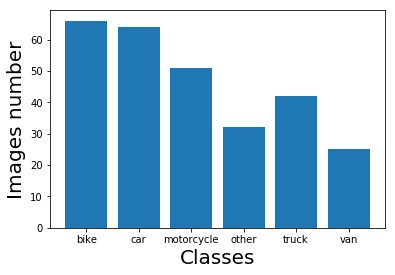

In [7]:
#visualize the classes distribution in the train data
plt.bar(train_raw_df.classes, train_raw_df.images_in_class)
plt.xlabel('Classes', fontsize=20)
plt.ylabel('Images number', fontsize=20);

In [8]:
# Create graph
img_graph = tf.Graph()

with img_graph.as_default():
    # Download module
    module_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2'
    feature_extractor = hub.Module(module_url)

    # Create input placeholder
    input_imgs = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 3])

    # A node with the features
    imgs_features = feature_extractor(input_imgs)

    # Collect initializers
    init_op = tf.group([
        tf.global_variables_initializer(), tf.tables_initializer()
    ])

img_graph.finalize() #make the graph "read-only"

#if the following error appears 
#RuntimeError: Missing implementation that supports: loader(*('C:\\Users\\matfr\\AppData\\Local\\Temp\\tfhub_modules\\adfe0cf8d843e3588bfb9602e32a718b12212904',), **{})
#just delete the folder at the indicated path

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
# Create a session
sess = tf.Session(graph=img_graph)

# Initialize it
sess.run(init_op)

# Extract features
features_train = sess.run(imgs_features, feed_dict={input_imgs: batch_imgs_train})#ensure that the proper data are fed to the graph
features_train.shape 

(280, 1280)

_______________
> <b>Validation</b>

_________

In [10]:
valset = generator_extraction.flow_from_directory(
    os.path.join('valid'), batch_size=139, target_size=(224, 224), color_mode='rgb',
    interpolation='bilinear',#bilinear is the default but better to outline it
    shuffle = False)

Found 139 images belonging to 6 classes.


In [11]:
batch_imgs_val, batch_labels_val = valset.next()
print('Batch images validation:', batch_imgs_val.shape) 
print('Batch labels validation:', batch_labels_val.shape)

Batch images validation: (139, 224, 224, 3)
Batch labels validation: (139, 6)


In [12]:
# Create a session
sess = tf.Session(graph=img_graph)

# Initialize
sess.run(init_op)

# Extract features
features_validation = sess.run(imgs_features, feed_dict={input_imgs: batch_imgs_val})#ensure that the proper data are fed to the graph
features_validation.shape 

(139, 1280)

____________
> <b>Test</b>

____________

In [13]:
testset = generator_extraction.flow_from_directory(
    os.path.join('test'), batch_size=50, target_size=(224, 224), color_mode='rgb',
    interpolation='bilinear',#bilinear is the default but better to outline it
    shuffle = False)

Found 50 images belonging to 6 classes.


In [14]:
batch_imgs_test, batch_labels_test = testset.next()
print('Batch images test:', batch_imgs_test.shape) 
print('Batch labels test:', batch_labels_test.shape)

Batch images test: (50, 224, 224, 3)
Batch labels test: (50, 6)


In [15]:
# Create a session
sess = tf.Session(graph=img_graph)

# Initialize
sess.run(init_op)

# Extract features
features_test = sess.run(imgs_features, feed_dict={input_imgs: batch_imgs_test})#ensure that the proper data are fed to the graph
features_test.shape 

(50, 1280)

_____________
> <b>1.3. Save high-level features</b>

___________

<br>Here I will save the the high-level features as npz files. Each npz file will contain different arrays:</br>
- features (features_train, features_validation, features_test)
- labels as integers (trainset.classes, valset.classes, testset.classes)
- the original preprocessed images ready to be plotted (batch_imgs_train, batch_imgs_val, batch_imgs_test)
- the images path name (train_imgs_path, validation_imgs_path, test_imgs_path)

<br>important: there is not shuffling in the data meaning that there is have a 1:1 correspondence across data (e.g. [0] in features_train will correspond to -> trainset.classes[0] -> batch_imgs_train[0] -> train_imgs_path[0]).</br>

First, I still need to extract the path names before saving the images.

In [16]:
#train
train_imgs_path = []

directory=os.listdir('train')
for each in directory:
    currentFolder = 'train/' + each
    for i, file in enumerate (os.listdir(currentFolder)[0:]):
        fullpath = currentFolder+ "/" + file
        train_imgs_path.append(fullpath)
        
#turn it into np array
train_imgs_path = np.array(train_imgs_path)

In [17]:
#validation
valid_imgs_path = []

directory=os.listdir('valid')
for each in directory:
    currentFolder = 'valid/' + each
    for i, file in enumerate (os.listdir(currentFolder)[0:]):
        fullpath = currentFolder+ "/" + file
        valid_imgs_path.append(fullpath)

#turn it into np array
valid_imgs_path = np.array(valid_imgs_path)

In [18]:
#test
test_imgs_path = []

directory=os.listdir('test')
for each in directory:
    currentFolder = 'test/' + each
    for i, file in enumerate (os.listdir(currentFolder)[0:]):
        fullpath = currentFolder+ "/" + file
        test_imgs_path.append(fullpath)
        
#turn it into np array
test_imgs_path = np.array(test_imgs_path)

In [19]:
np.savez('features_mobilenet_v2.npz',
         #features
         train_hl = features_train, #_hl stands for high-Level
         validation_hl = features_validation,
         test_hl = features_test,
         #labels
         labels_train = trainset.classes,
         labels_validation = valset.classes,
         labels_test = testset.classes,
         #imgs
         train_imgs = batch_imgs_train,
         validation_imgs = batch_imgs_val,
         test_imgs = batch_imgs_test,
         #paths
         train_imgs_path = train_imgs_path,
         valid_imgs_path = valid_imgs_path,
         test_imgs_path = test_imgs_path)

In [20]:
# reload the data (this is not necessary but defines once and for all the set names)
with np.load('features_mobilenet_v2.npz', allow_pickle=False) as npz_file:
    #features
    X_train = npz_file['train_hl']
    X_val = npz_file['validation_hl']
    X_test = npz_file['test_hl']
    #labels
    y_train = npz_file['labels_train']
    y_val = npz_file['labels_validation']
    y_test = npz_file['labels_test']
    #imgs
    train_imgs = npz_file['train_imgs']
    validation_imgs = npz_file['validation_imgs']
    test_imgs = npz_file['test_imgs']
    #paths
    train_imgs_path = npz_file['train_imgs_path']
    valid_imgs_path = npz_file['valid_imgs_path']
    test_imgs_path = npz_file['test_imgs_path']
    
print('X_train:', X_train.shape, 'labels:', y_train.shape) 
print('X_val:', X_val.shape, 'labels:', y_val.shape) 
print('X_test:', X_test.shape, 'labels:', y_test.shape) 
print('train_imgs:', train_imgs.shape, 'validation_imgs:', validation_imgs.shape, 'test_imgs:', test_imgs.shape,)
print('train_imgs_path:', train_imgs_path.shape, 'valid_imgs_path:', valid_imgs_path.shape, 'test_imgs_path:', test_imgs_path.shape)

X_train: (280, 1280) labels: (280,)
X_val: (139, 1280) labels: (139,)
X_test: (50, 1280) labels: (50,)
train_imgs: (280, 224, 224, 3) validation_imgs: (139, 224, 224, 3) test_imgs: (50, 224, 224, 3)
train_imgs_path: (280,) valid_imgs_path: (139,) test_imgs_path: (50,)
